In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import concatenate
import optuna
import xgboost as xgb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [6]:

file_path = "/content/Enhanced_Processed_Financial_Data.csv"

merged_df_cleaned = pd.read_csv(file_path)

print(merged_df_cleaned.head())


lag_steps = 1

def sequential_to_supervised(data, lag_steps=1, dropnan=True):
    df = pd.DataFrame(data)
    cols = [df.shift(i) for i in range(lag_steps, 0, -1)] + [df]
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg



Loading dataset...
Dataset loaded. First few rows:
   Unnamed: 0       BDI       CPI      EFFR       IPI  Unemployment  \
0          11 -0.644072  1.077695  0.259805 -0.981753      0.097132   
1          12 -0.644072  0.763882  0.089210 -1.015562      0.097132   
2          13 -0.644072  0.601610  0.102789 -1.009775      0.160665   
3          14 -0.644072  0.441023  0.226799 -0.787657      0.097132   
4          15 -0.644072  0.582020  0.348562 -0.617147      0.097132   

   CRB_Change  Fed_Assets_Change  PCE_Change  SP500_Change  USD_Index_Change  \
0   -0.151658           0.904350   -0.136684     -0.268744          0.008760   
1    1.391107          -0.740962    0.299657     -0.268744         -0.076836   
2   -0.358502          -0.867269    0.513742     -0.268744         -0.016110   
3    0.122169          -0.182015    0.862074     -0.268744          0.033875   
4   -0.575560          -2.232555    0.989300     -0.268744         -0.400897   

   CRB_MA_3  CRB_MA_6  CRB_MA_12  CRB_Lag

In [7]:
print("Preparing features and target...")
features = merged_df_cleaned.drop(columns=["CRB_Change"])
target = merged_df_cleaned["CRB_Change"]

dataset = pd.concat([features, target], axis=1)
supervised_dataset = sequential_to_supervised(dataset, lag_steps)


cols_at_end = ["CRB_Change"]
supervised_dataset = supervised_dataset[[c for c in supervised_dataset if c not in cols_at_end] + cols_at_end]

print(supervised_dataset.head())


scaler = MinMaxScaler(feature_range=(0, 1))
supervised_scaled = scaler.fit_transform(supervised_dataset)



split = int(supervised_scaled.shape[0] * 0.8)
train, test = supervised_scaled[:split, :], supervised_scaled[split:, :]



train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]



train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


Preparing features and target...
Supervised dataset prepared. First few rows:
   Unnamed: 0  Unnamed: 0       BDI       BDI       CPI       CPI      EFFR  \
1        11.0          12 -0.644072 -0.644072  1.077695  0.763882  0.259805   
2        12.0          13 -0.644072 -0.644072  0.763882  0.601610  0.089210   
3        13.0          14 -0.644072 -0.644072  0.601610  0.441023  0.102789   
4        14.0          15 -0.644072 -0.644072  0.441023  0.582020  0.226799   
5        15.0          16 -0.644072 -0.644072  0.582020  0.569129  0.348562   

       EFFR       IPI       IPI  ...  CRB_Lag_1  CRB_Lag_1  CRB_Lag_2  \
1  0.089210 -0.981753 -1.015562  ...  -1.055348  -0.104648  -0.908097   
2  0.102789 -1.015562 -1.009775  ...  -0.104648   1.446332  -1.046795   
3  0.226799 -1.009775 -0.787657  ...   1.446332  -0.312593  -0.107112   
4  0.348562 -0.787657 -0.617147  ...  -0.312593   0.170637   1.425896   
5  0.406993 -0.617147 -0.412523  ...   0.170637  -0.530807  -0.312647   

   CRB_L

# Optuna + LSTM

In [2]:
!pip install optuna



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.3 MB/s eta 0:00:00


In [12]:
!pip install optuna xgboost prophet

In [38]:
split_val = int(train_X.shape[0] * 0.85)
val_X, train_X = train_X[split_val:], train_X[:split_val]
val_y, train_y = train_y[split_val:], train_y[:split_val]


In [39]:


def objective(trial):
    n_lstm_1 = trial.suggest_int("n_lstm_1", 32, 128)
    n_lstm_2 = trial.suggest_int("n_lstm_2", 16, 64)
    dropout_rate = trial.suggest_float("dropout", 0.15, 0.35)
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    model = Sequential()
    model.add(LSTM(n_lstm_1, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]),
                   kernel_regularizer=l2(l2_reg), recurrent_dropout=dropout_rate))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(LSTM(n_lstm_2, return_sequences=False, dropout=dropout_rate))
    model.add(BatchNormalization())

    model.add(Dense(1, kernel_regularizer=l2(l2_reg)))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=1.0)
    model.compile(loss="mae", optimizer=optimizer)

    early_stopping = EarlyStopping(monitor="val_loss", patience=7, min_delta=0.0005, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

    model.fit(train_X, train_y, epochs=70, batch_size=batch_size,
              validation_data=(val_X, val_y), verbose=0, shuffle=False,
              callbacks=[early_stopping, lr_scheduler])

    yhat = model.predict(test_X)
    inv_yhat = scaler.inverse_transform(np.concatenate((test_X.reshape(test_X.shape[0], -1), yhat), axis=1))[:, -1]
    inv_y = scaler.inverse_transform(np.concatenate((test_X.reshape(test_X.shape[0], -1), test_y.reshape(-1, 1)), axis=1))[:, -1]

    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    return rmse


In [40]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)


[I 2025-02-22 23:36:08,843] A new study created in memory with name: no-name-39a0c19e-882b-43d3-8139-cfed01f1dffb
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2025-02-22 23:36:15,962] Trial 0 finished with value: 0.9967854070192198 and parameters: {'n_lstm_1': 127, 'n_lstm_2': 61, 'dropout': 0.21324577354623842, 'l2_reg': 0.0006592500736139195, 'batch_size': 16, 'learning_rate': 0.009188740815057028}. Best is trial 0 with value: 0.9967854070192198.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


[I 2025-02-22 23:36:23,820] Trial 1 finished with value: 1.0192231219725345 and parameters: {'n_lstm_1': 59, 'n_lstm_2': 38, 'dropout': 0.23170531917025985, 'l2_reg': 6.105427956321156e-05, 'batch_size': 32, 'learning_rate': 0.004179976064695383}. Best is trial 0 with value: 0.9967854070192198.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step


[I 2025-02-22 23:36:38,338] Trial 2 finished with value: 0.9017177013227528 and parameters: {'n_lstm_1': 62, 'n_lstm_2': 37, 'dropout': 0.2729879083721526, 'l2_reg': 0.00027703057470006303, 'batch_size': 16, 'learning_rate': 0.00030222166227004174}. Best is trial 2 with value: 0.9017177013227528.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


[I 2025-02-22 23:36:48,285] Trial 3 finished with value: 1.0149924363994016 and parameters: {'n_lstm_1': 74, 'n_lstm_2': 24, 'dropout': 0.2832222746508339, 'l2_reg': 8.246152117344706e-05, 'batch_size': 64, 'learning_rate': 0.001556901541846273}. Best is trial 2 with value: 0.9017177013227528.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step


[I 2025-02-22 23:36:57,483] Trial 4 finished with value: 1.0290542571655947 and parameters: {'n_lstm_1': 111, 'n_lstm_2': 34, 'dropout': 0.27270800243129667, 'l2_reg': 0.0005258471822872968, 'batch_size': 64, 'learning_rate': 0.004445863778388035}. Best is trial 2 with value: 0.9017177013227528.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


[I 2025-02-22 23:37:10,308] Trial 5 finished with value: 1.4584173156819724 and parameters: {'n_lstm_1': 102, 'n_lstm_2': 28, 'dropout': 0.2759914011905313, 'l2_reg': 2.159356646312716e-05, 'batch_size': 64, 'learning_rate': 0.00039401482868314607}. Best is trial 2 with value: 0.9017177013227528.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


[I 2025-02-22 23:37:18,297] Trial 6 finished with value: 1.0368875941953477 and parameters: {'n_lstm_1': 107, 'n_lstm_2': 53, 'dropout': 0.21434824481869238, 'l2_reg': 0.00032262541735278487, 'batch_size': 64, 'learning_rate': 0.004911045058648001}. Best is trial 2 with value: 0.9017177013227528.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


[I 2025-02-22 23:37:26,543] Trial 7 finished with value: 0.985793434294169 and parameters: {'n_lstm_1': 75, 'n_lstm_2': 18, 'dropout': 0.20610418646672268, 'l2_reg': 0.0001649648505249409, 'batch_size': 16, 'learning_rate': 0.008832065902138718}. Best is trial 2 with value: 0.9017177013227528.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


[I 2025-02-22 23:37:41,955] Trial 8 finished with value: 1.2311244140282849 and parameters: {'n_lstm_1': 128, 'n_lstm_2': 46, 'dropout': 0.22402334654947098, 'l2_reg': 1.7342615883428086e-05, 'batch_size': 32, 'learning_rate': 0.00020726742751825189}. Best is trial 2 with value: 0.9017177013227528.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


[I 2025-02-22 23:37:49,998] Trial 9 finished with value: 1.0183605155905153 and parameters: {'n_lstm_1': 49, 'n_lstm_2': 29, 'dropout': 0.1875612857217791, 'l2_reg': 0.00036729333449888376, 'batch_size': 16, 'learning_rate': 0.002734938553345658}. Best is trial 2 with value: 0.9017177013227528.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


[I 2025-02-22 23:37:59,181] Trial 10 finished with value: 1.0511760375425963 and parameters: {'n_lstm_1': 33, 'n_lstm_2': 46, 'dropout': 0.34537026452740416, 'l2_reg': 0.0001846881825321949, 'batch_size': 16, 'learning_rate': 0.000610088110720367}. Best is trial 2 with value: 0.9017177013227528.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


[I 2025-02-22 23:38:13,192] Trial 11 finished with value: 1.7578120794876029 and parameters: {'n_lstm_1': 81, 'n_lstm_2': 17, 'dropout': 0.16371209258555447, 'l2_reg': 0.00014780447488403227, 'batch_size': 16, 'learning_rate': 0.00013712825921006195}. Best is trial 2 with value: 0.9017177013227528.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


[I 2025-02-22 23:38:22,671] Trial 12 finished with value: 1.0243117336023184 and parameters: {'n_lstm_1': 79, 'n_lstm_2': 16, 'dropout': 0.333509722367747, 'l2_reg': 5.113202319020458e-05, 'batch_size': 16, 'learning_rate': 0.0008923589996765227}. Best is trial 2 with value: 0.9017177013227528.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


[I 2025-02-22 23:38:37,201] Trial 13 finished with value: 0.8159719566944011 and parameters: {'n_lstm_1': 62, 'n_lstm_2': 22, 'dropout': 0.30752766954313304, 'l2_reg': 0.0002074929130821987, 'batch_size': 16, 'learning_rate': 0.00032833287111647927}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


[I 2025-02-22 23:38:52,122] Trial 14 finished with value: 1.3304534025423143 and parameters: {'n_lstm_1': 57, 'n_lstm_2': 45, 'dropout': 0.30993700898106985, 'l2_reg': 0.000285614144619221, 'batch_size': 16, 'learning_rate': 0.0002977963345676228}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


[I 2025-02-22 23:39:05,699] Trial 15 finished with value: 3.1133405901369873 and parameters: {'n_lstm_1': 41, 'n_lstm_2': 34, 'dropout': 0.30649138819177424, 'l2_reg': 0.0009662035543450153, 'batch_size': 16, 'learning_rate': 0.00010822529219842961}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step


[I 2025-02-22 23:39:20,282] Trial 16 finished with value: 1.0013996674957661 and parameters: {'n_lstm_1': 63, 'n_lstm_2': 24, 'dropout': 0.2491974428175658, 'l2_reg': 3.585525654362503e-05, 'batch_size': 32, 'learning_rate': 0.0005053522170793014}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


[I 2025-02-22 23:39:36,922] Trial 17 finished with value: 1.618753914906318 and parameters: {'n_lstm_1': 91, 'n_lstm_2': 54, 'dropout': 0.30577789462840105, 'l2_reg': 1.0103496625013363e-05, 'batch_size': 16, 'learning_rate': 0.00022976750997092378}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


[I 2025-02-22 23:39:45,560] Trial 18 finished with value: 1.007311235113983 and parameters: {'n_lstm_1': 64, 'n_lstm_2': 41, 'dropout': 0.25067322581340656, 'l2_reg': 0.00011305320278484945, 'batch_size': 16, 'learning_rate': 0.0009692828369805354}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


[I 2025-02-22 23:40:11,434] Trial 19 finished with value: 1.0290835409070889 and parameters: {'n_lstm_1': 47, 'n_lstm_2': 23, 'dropout': 0.3270039172812134, 'l2_reg': 0.00022857842810442182, 'batch_size': 32, 'learning_rate': 0.0015528484010699066}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


[I 2025-02-22 23:40:24,007] Trial 20 finished with value: 1.432419794469181 and parameters: {'n_lstm_1': 90, 'n_lstm_2': 32, 'dropout': 0.2887654699256341, 'l2_reg': 0.0005425937123468068, 'batch_size': 16, 'learning_rate': 0.00015539985135012112}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


[I 2025-02-22 23:40:34,389] Trial 21 finished with value: 1.8762976130450433 and parameters: {'n_lstm_1': 68, 'n_lstm_2': 20, 'dropout': 0.15253511112322854, 'l2_reg': 0.00013310720288421755, 'batch_size': 16, 'learning_rate': 0.00030554638717161163}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step


[I 2025-02-22 23:40:52,756] Trial 22 finished with value: 0.9810687926315954 and parameters: {'n_lstm_1': 72, 'n_lstm_2': 20, 'dropout': 0.2516690733338938, 'l2_reg': 0.0001995769859044778, 'batch_size': 16, 'learning_rate': 0.009306291379132288}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step


[I 2025-02-22 23:41:03,969] Trial 23 finished with value: 0.9834944024986113 and parameters: {'n_lstm_1': 87, 'n_lstm_2': 28, 'dropout': 0.2474165192804673, 'l2_reg': 0.00023315037408750457, 'batch_size': 16, 'learning_rate': 0.0006435552869643349}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


[I 2025-02-22 23:41:13,307] Trial 24 finished with value: 1.0202668961190478 and parameters: {'n_lstm_1': 53, 'n_lstm_2': 39, 'dropout': 0.2613499256383259, 'l2_reg': 0.0003895349537787553, 'batch_size': 16, 'learning_rate': 0.001388904360937031}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step


[I 2025-02-22 23:41:28,279] Trial 25 finished with value: 1.2172091873118236 and parameters: {'n_lstm_1': 69, 'n_lstm_2': 21, 'dropout': 0.294409575775429, 'l2_reg': 8.505065390806716e-05, 'batch_size': 16, 'learning_rate': 0.00040796003059101715}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step


[I 2025-02-22 23:41:37,140] Trial 26 finished with value: 1.0232202944486037 and parameters: {'n_lstm_1': 44, 'n_lstm_2': 26, 'dropout': 0.26229613308519006, 'l2_reg': 0.00020231142459852582, 'batch_size': 16, 'learning_rate': 0.0023978986775186825}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


[I 2025-02-22 23:41:51,597] Trial 27 finished with value: 1.2314066600943399 and parameters: {'n_lstm_1': 34, 'n_lstm_2': 31, 'dropout': 0.23727519568206418, 'l2_reg': 0.00010538653672563617, 'batch_size': 16, 'learning_rate': 0.00019579974097247638}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


[I 2025-02-22 23:42:01,487] Trial 28 finished with value: 1.0660039743918845 and parameters: {'n_lstm_1': 57, 'n_lstm_2': 55, 'dropout': 0.320263371615812, 'l2_reg': 0.000413274630329177, 'batch_size': 32, 'learning_rate': 0.0007778720473254355}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


[I 2025-02-22 23:42:09,613] Trial 29 finished with value: 1.0575981443600604 and parameters: {'n_lstm_1': 69, 'n_lstm_2': 62, 'dropout': 0.26386022648888063, 'l2_reg': 0.0006576385499970629, 'batch_size': 64, 'learning_rate': 0.008293272630932361}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


[I 2025-02-22 23:42:24,349] Trial 30 finished with value: 1.073230337198936 and parameters: {'n_lstm_1': 84, 'n_lstm_2': 36, 'dropout': 0.29489210091947304, 'l2_reg': 0.0009357502596369103, 'batch_size': 16, 'learning_rate': 0.0003073805467342667}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


[I 2025-02-22 23:42:34,980] Trial 31 finished with value: 1.011994154483054 and parameters: {'n_lstm_1': 89, 'n_lstm_2': 27, 'dropout': 0.24585836313484316, 'l2_reg': 0.00025700673236728644, 'batch_size': 16, 'learning_rate': 0.0006572235957457823}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


[I 2025-02-22 23:42:45,977] Trial 32 finished with value: 0.9993052409763011 and parameters: {'n_lstm_1': 100, 'n_lstm_2': 20, 'dropout': 0.2295549904395666, 'l2_reg': 0.00023022991917434962, 'batch_size': 16, 'learning_rate': 0.0004659881245221544}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


[I 2025-02-22 23:42:58,288] Trial 33 finished with value: 0.9134112302357054 and parameters: {'n_lstm_1': 75, 'n_lstm_2': 30, 'dropout': 0.27951406013252994, 'l2_reg': 7.346247666123446e-05, 'batch_size': 16, 'learning_rate': 0.0012403693392690307}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


[I 2025-02-22 23:43:12,579] Trial 34 finished with value: 0.909988099907793 and parameters: {'n_lstm_1': 75, 'n_lstm_2': 23, 'dropout': 0.2829254903693289, 'l2_reg': 6.165847362509881e-05, 'batch_size': 16, 'learning_rate': 0.002323923092032509}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


[I 2025-02-22 23:43:21,773] Trial 35 finished with value: 1.0177435627999307 and parameters: {'n_lstm_1': 62, 'n_lstm_2': 31, 'dropout': 0.27873628445650356, 'l2_reg': 5.96463974581673e-05, 'batch_size': 64, 'learning_rate': 0.0021302586638966008}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


[I 2025-02-22 23:43:30,061] Trial 36 finished with value: 1.0131000103148582 and parameters: {'n_lstm_1': 77, 'n_lstm_2': 36, 'dropout': 0.26957877263461427, 'l2_reg': 4.019743076415329e-05, 'batch_size': 16, 'learning_rate': 0.0012771211268534767}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


[I 2025-02-22 23:43:38,167] Trial 37 finished with value: 1.0534334478447998 and parameters: {'n_lstm_1': 54, 'n_lstm_2': 24, 'dropout': 0.28316730712058397, 'l2_reg': 8.697280589490861e-05, 'batch_size': 64, 'learning_rate': 0.003661449228987456}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


[I 2025-02-22 23:43:46,280] Trial 38 finished with value: 1.069503617056635 and parameters: {'n_lstm_1': 116, 'n_lstm_2': 25, 'dropout': 0.31399147712652864, 'l2_reg': 3.030762192790835e-05, 'batch_size': 32, 'learning_rate': 0.001325837052272517}. Best is trial 13 with value: 0.8159719566944011.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


[I 2025-02-22 23:43:53,626] Trial 39 finished with value: 1.0526418729857958 and parameters: {'n_lstm_1': 97, 'n_lstm_2': 42, 'dropout': 0.30054391910524625, 'l2_reg': 7.017772513735084e-05, 'batch_size': 16, 'learning_rate': 0.0018289771475223716}. Best is trial 13 with value: 0.8159719566944011.


In [47]:
print("Best hyperparameters found by Optuna:")
print(study.best_params)
print(model.summary())

Best hyperparameters found by Optuna:
{'n_lstm_1': 62, 'n_lstm_2': 22, 'dropout': 0.30752766954313304, 'l2_reg': 0.0002074929130821987, 'batch_size': 16, 'learning_rate': 0.00032833287111647927}


Model: "sequential_255"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_508 (LSTM)                      │ (None, 1, 62)               │          32,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_294              │ (None, 1, 62)               │             248 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_286 (Dropout)                │ (None, 1, 62)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_509 (LSTM)                      │ (None, 22)                  │           7,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_254 (Dense)                    │ (None, 1)                   │              23 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,487 (158.15 KB)

 Trainable params: 40,363 (157.67 KB)

 Non-trainable params: 124 (496.00 B)

None


In [32]:
from tensorflow.keras.models import load_model

model.save("best_lstm_model.h5")
print("LSTM model saved successfully!")


# loaded_model = load_model("best_lstm_model.h5")


LSTM model saved successfully!


In [42]:
import pandas as pd
from sklearn.metrics import r2_score


xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(train_X.reshape(train_X.shape[0], -1), train_y)
xgb_pred = xgb_model.predict(test_X.reshape(test_X.shape[0], -1))
rmse_xgb = np.sqrt(mean_squared_error(inv_y, xgb_pred))
r2_xgb = r2_score(inv_y, xgb_pred)
print(f"XGBoost Test RMSE: {rmse_xgb:.5f}")
print(f"XGBoost Test R²: {r2_xgb:.4f}")



ols_model = sm.OLS(train_y, sm.add_constant(train_X.reshape(train_X.shape[0], -1))).fit()
ols_pred = ols_model.predict(sm.add_constant(test_X.reshape(test_X.shape[0], -1)))
rmse_ols = np.sqrt(mean_squared_error(inv_y, ols_pred))
r2_ols = r2_score(inv_y, ols_pred)
print(f"OLS Test RMSE: {rmse_ols:.5f}")
print(f"OLS Test R²: {r2_ols:.4f}")


print("\nModel Performance Comparison:")
print(f"LSTM Test RMSE: {rmse_lstm:.5f}, R²: {r2_lstm:.4f}")
print(f"XGBoost Test RMSE: {rmse_xgb:.5f}, R²: {r2_xgb:.4f}")
print(f"OLS Test RMSE: {rmse_ols:.5f}, R²: {r2_ols:.4f}")

comparison_df = pd.DataFrame({
    "Model": ["LSTM", "XGBoost", "OLS"],
    "RMSE": [rmse_lstm, rmse_xgb, rmse_ols],
    "R² Score": [r2_lstm, r2_xgb, r2_ols]
})
print(comparison_df)




Training XGBoost model...
XGBoost Test RMSE: 1.01525
XGBoost Test R²: 0.0232
Fitting OLS model...
OLS Test RMSE: 0.94736
OLS Test R²: 0.1495

Model Performance Comparison:
LSTM Test RMSE: 0.48417, R²: 0.6852
XGBoost Test RMSE: 1.01525, R²: 0.0232
OLS Test RMSE: 0.94736, R²: 0.1495
     Model      RMSE  R² Score
0     LSTM  0.484165  0.685248
1  XGBoost  1.015247  0.023180
2      OLS  0.947357  0.149453


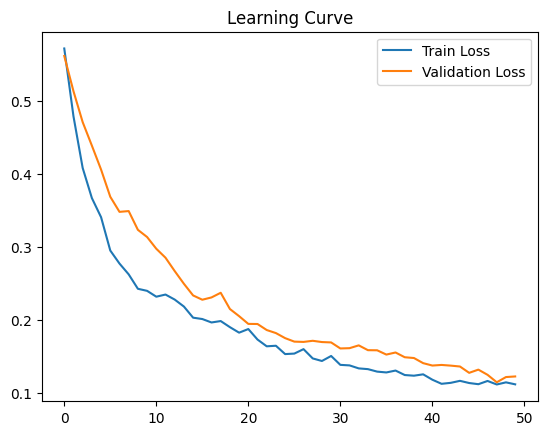

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()


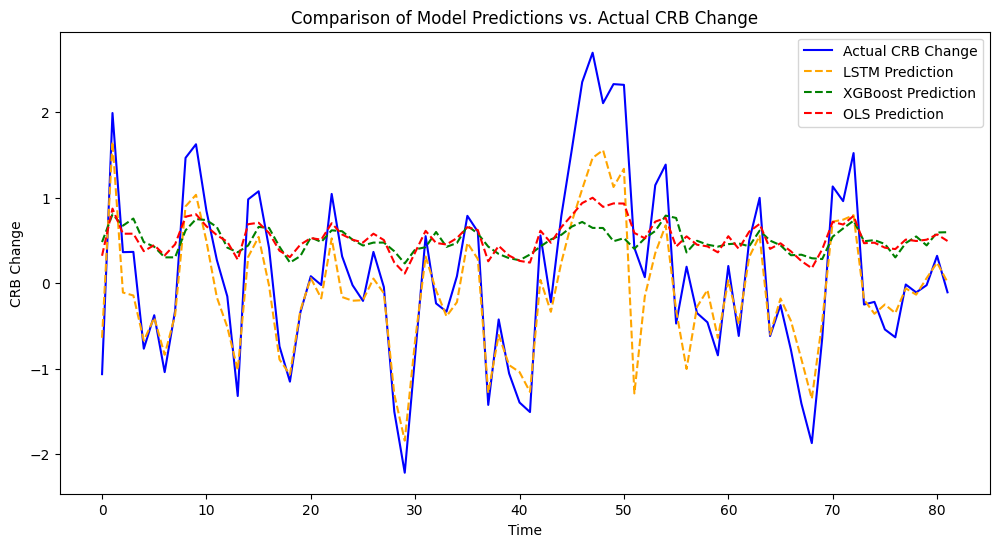

In [44]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
plt.plot(inv_y, label='Actual CRB Change', color='blue')
plt.plot(inv_yhat, label='LSTM Prediction', linestyle='dashed', color='orange')
plt.plot(xgb_pred, label='XGBoost Prediction', linestyle='dashed', color='green')
plt.plot(ols_pred, label='OLS Prediction', linestyle='dashed', color='red')

plt.legend()
plt.xlabel("Time")
plt.ylabel("CRB Change")
plt.title("Comparison of Model Predictions vs. Actual CRB Change")
plt.show()


In [45]:
import scipy.stats as stats

corr_lstm, _ = stats.pearsonr(inv_y, inv_yhat)
corr_xgb, _ = stats.pearsonr(inv_y, xgb_pred)
corr_ols, _ = stats.pearsonr(inv_y, ols_pred)


print(f"LSTM Correlation with Actual: {corr_lstm:.4f}")
print(f"XGBoost Correlation with Actual: {corr_xgb:.4f}")
print(f"OLS Correlation with Actual: {corr_ols:.4f}")


corr_df = pd.DataFrame({
    "Model": ["LSTM", "XGBoost", "OLS"],
    "Correlation": [corr_lstm, corr_xgb, corr_ols]
})
print("\nCorrelation of Predictions with Actual Values:")
print(corr_df)


LSTM Correlation with Actual: 0.9367
XGBoost Correlation with Actual: 0.7217
OLS Correlation with Actual: 1.0000

Correlation of Predictions with Actual Values:
     Model  Correlation
0     LSTM     0.936712
1  XGBoost     0.721696
2      OLS     1.000000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


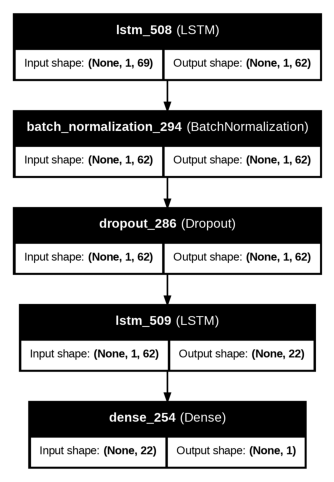

In [46]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image

best_params = study.best_params

model = Sequential()
model.add(LSTM(best_params["n_lstm_1"], return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]),
               kernel_regularizer=l2(best_params["l2_reg"]), recurrent_dropout=best_params["dropout"]))
model.add(BatchNormalization())
model.add(Dropout(best_params["dropout"]))
model.add(LSTM(best_params["n_lstm_2"], return_sequences=False, dropout=best_params["dropout"]))
model.add(Dense(1, kernel_regularizer=l2(best_params["l2_reg"])))


plot_model(model, to_file="lstm_architecture.png", show_shapes=True, show_layer_names=True)

img = Image.open("lstm_architecture.png")
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.show()
